<a href="https://colab.research.google.com/github/MMRES-PyBootcamp/MMRES-python-bootcamp2022/blob/main/13_Neural_Networks_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Again, make sure to enable GPU acceleration in runtime

![Open Runtime/change runtime](data/colab_GPU1.png)

![Choose GPU in hardware accelerator](data/colab_GPU2.png)

In [1]:
import torch
from torch import nn
from torchvision import datasets
from torchvision.transforms import ToTensor

/home/qottmann/anaconda3/envs/test/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We are looking at the same MNIST dataset of handwritten digits and want to make some adjustments to our neural network architecture to improve our performance. First, we load the dataset again.

In [15]:
device = "cpu" #"cuda" #make sure colab runtime has GPU acceleration activated

In [16]:
# Download training data from open datasets.
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [17]:
from torch.utils.data import DataLoader

batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    X_ex = X
    print(f"Shape of X [batch_size, color_channel, height, width]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [batch_size, color_channel, height, width]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


We keep the fully connected layers, but first add a convolutional block. This block acts as a so-called feature extractor, finding shapes and patterns in the data. These features are then classified with the fully-connected block.  
Check the documentation for the convolutional layer: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
Documentation for the maxpooling layer: https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html

In [18]:
out_dim = 10

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding="same"), # (28 x 28 x 1) -> (28 x 28 x 16)
            nn.ReLU(),
            nn.MaxPool2d(2),                         # (28 x 28 x 16) -> (14 x 14 x 16)
            nn.Conv2d(16, 16, 3, padding="same"),    # (14 x 14 x 16) -> (14 x 14 x 16)
            nn.ReLU(),
            nn.MaxPool2d(2),                         # (14 x 14 x 16) -> (7  x 7  x 16)
            nn.Conv2d(16, 16, 3, padding="same"),    # (7  x 7  x 16) -> (7  x 7  x 16)
            nn.ReLU(),
            nn.Flatten())                            # (7  x 7  x 16) ->  (7*7*16)
        self.dense_block = nn.Sequential(
            nn.Linear(7*7*16, 512),  # input dimension, hidden1 dimension
            nn.ReLU(),               # Non-linear activation function
            nn.Linear(512, 512),     # hidden1 dimension, hidden2 dimension
            nn.ReLU(),               # Non-linear activation function
            nn.Linear(512, out_dim), # hidden2 dimension, output dimension
        )

    def forward(self, x):
        features = self.conv_block(x)
        output = self.dense_block(features)
        return output

In [19]:
model = NeuralNetwork().to(device) #uncomment for GPU execution
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (conv_block): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (7): ReLU()
    (8): Flatten(start_dim=1, end_dim=-1)
  )
  (dense_block): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [21]:
# quick test to see if the dimensions match
model(X_ex.to(device)).shape

torch.Size([64, 10])

In [15]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    correct = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 2 == 0:
            loss, current = loss.item(), batch * len(X)
            #print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    # compute accuracy
    train_acc = correct/size * 100
    return loss, train_acc

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    test_acc = 100*correct
    print(f"Test Error: Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}")
    return test_loss, test_acc



In [16]:
epochs = 2
train_losss, train_accs = [], []
test_losss, test_accs = [], []
for t in range(epochs):
    print(f"Epoch {t+1}")
    train_loss, train_acc = train(train_dataloader, model, loss_fn, optimizer)
    test_loss, test_acc = test(test_dataloader, model, loss_fn)
    train_losss.append(train_loss)
    train_accs.append(train_acc)
    test_losss.append(test_loss)
    test_accs.append(test_acc)
print("Done!")

Epoch 1
Test Error: Accuracy: 21.3%, Avg loss: -1.122009
Epoch 2
Test Error: Accuracy: 9.8%, Avg loss:      nan
Done!


In [ ]:
train_losss = torch.tensor(train_losss).cpu()
train_accs = torch.tensor(train_accs).cpu()
test_losss = torch.tensor(test_losss).cpu()
test_accs = torch.tensor(test_accs).cpu()

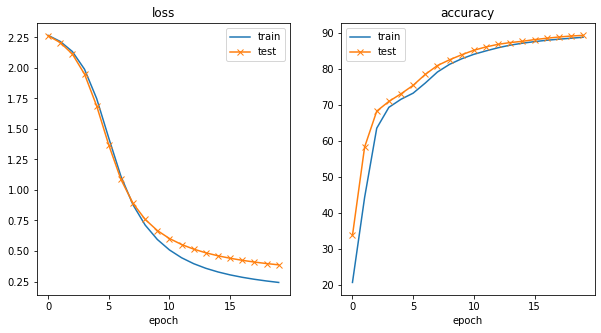

In [ ]:
fig, axs = plt.subplots(figsize=(10,5), ncols=2)

ax = axs[0]
ax.plot(train_losss.cpu(), label="train")
ax.plot(test_losss.cpu(), "x-", label="test")

ax.set_title("loss")
ax.set_xlabel("epoch")
ax.legend()

ax = axs[1]
ax.plot(train_accs.cpu(), label="train")
ax.plot(test_accs.cpu(), "x-", label="test")

ax.set_title("accuracy")
ax.set_xlabel("epoch")
ax.legend()